# Text Similarity

*EarlyPrint*'s [Discovery Engine](https://earlyprint.org/lab/tool_discovery_engine.html?which_to_do=find_texts&eebo_tcp_id=A43441&n_results=35&tfidf_weight=6&mallet_weight=6&tag_weight=6) allows you to find a set of texts similar to any text in our corpus. It does this by using some basic measures of text similarity, and it's easy to use if you're interested in finding similar texts across the entire early modern corpus.

But you might be interested in finding similarity across a smaller subset of the corpus. In this tutorial, we'll calculate similarity across the same set of 1666 texts that we used in the [TF-IDF tutorial](https://earlyprint.org/jupyterbook/tf_idf.html). You could easily do the same with any subset of texts that you've gathered using the [Metadata tutorial](https://earlyprint.org/jupyterbook/metadata.html).

This tutorial is meant as a companion to an explanation of text similarity that I wrote for *The Programming Historian*:

> [Understanding and Using Common Similarity Measures for Text Analysis](https://programminghistorian.org/en/lessons/common-similarity-measures)

The article uses the same 1666 corpus as its example, but here we'll work directly with the *EarlyPrint* XML instead of with plaintext files. For full explanations of the different similarity measures and how they're used, please use that piece as a guide.

First, we'll import necessary libraries. [n.b. In the *Programming Historian* tutorial, I use `scipy`'s implementation of pairwise distances. For simplicity's sake, here we're using Sci-kit Learn's built-in distance function.]

In [52]:
import glob
import pandas as pd
from lxml import etree
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import pairwise_distances
from collections import Counter

Next we use `glob` to get our list of files and isolate the filekeys to use later. This is the complete list of texts we're working with in this example. You may have a different directory or filepath for your own files.

In [53]:
# Use the glob library to create a list of file names
filenames = glob.glob("1666_texts/*.xml")
# Parse those filenames to create a list of file keys (ID numbers)
# You'll use these later on.
filekeys = [f.split('/')[-1].split('.')[0] for f in filenames]
print(filekeys)

['B02845', 'A51130', 'A36358', 'A28171', 'A51877', 'A60482', 'A32566', 'A35206', 'A35114', 'A32207', 'A39345', 'A25743', 'A86466', 'A61929', 'B03114', 'A32916', 'A70852', 'B01661', 'A61594', 'A35608', 'A64861', 'A61503', 'A79302', 'A62436', 'A38556', 'A32751', 'A63370', 'A57484', 'A92820', 'A39246', 'A87622', 'A66752', 'A26426', 'A26249', 'A55410', 'A46087', 'A31237', 'A61867', 'A61891', 'B05835', 'A28989', 'A31124', 'A80818', 'A65296', 'A30203', 'A55387', 'A59325', 'B06022', 'A56381', 'A61600', 'A66777', 'A39714', 'A44801', 'A71109', 'A49213', 'A43020', 'A45206', 'A95690', 'A60606', 'A23770', 'A52519', 'A44938', 'A64258', 'A70867', 'A35851', 'A56390', 'B02572', 'A91186', 'A59229', 'B05308', 'A30143', 'A46046', 'B03376', 'B03317', 'A47095', 'B01318', 'B03106', 'A44879', 'A54070', 'A70287', 'A28209', 'B04153', 'A29017', 'A70866', 'A47367', 'A44334', 'B03109', 'B02123', 'A42533', 'A42537', 'A44627', 'A93280', 'A38792', 'B06375', 'A67572', 'A46030', 'A32581', 'A44478', 'A47379', 'A41072',

## Get Features

In order to measure similarity between texts, you need features of those texts to measure. The [Discovery Engine](https://earlyprint.org/lab/tool_discovery_engine.html?which_to_do=find_texts&eebo_tcp_id=A43441&n_results=35&tfidf_weight=6&mallet_weight=6&tag_weight=6) calculates similarity across three distinct sets of features for the same texts: TF-IDF weights for word counts, LDA Topic Modeling results, and XML tag structures. As our example here, we'll use TF-IDF.

The code below is taken directly from the [TF-IDF Tutorial](https://earlyprint.org/jupyterbook/tf_idf.html), where you'll find a full explanation of what it does. We loop through each text, extract words, count them, and convert those counts to TF-IDF values. 

n.b. There are two key differences between the TF-IDF tutorial and this one. Below I am getting counts of **lemmas**, dictionary headwords, rather than simply regularized forms of the word. This allows us to group plurals or verb forms into a single term. Also, here we'll use [L2 normalization](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm) on our TF-IDF transformation. Normalizing values helps us account for very long or very short texts that may skew our similarity results.

In [54]:
# Create an empty lists to put all our texts into
all_tokenized = []

# Then you can loop through the files
for f in filenames:
    parser = etree.XMLParser(collect_ids=False) # Create a parse object that skips XML IDs (in this case they just slow things down)
    tree = etree.parse(f, parser) # Parse each file into an XML tree
    xml = tree.getroot() # Get the XML from that tree
    
    # Now we can use lxml to find all the w tags       
    word_tags = xml.findall(".//{*}w")
    # In this next line you'll do several things at once to create a list of words for each text
    # 1. Loop through each word: for word in word_tags
    # 2. Make sure the tag has a word at all: if word.text != None
    # 3. Get the lemmatized form of the word: word.get('reg', word.text)
    # 4. Make sure all the words are in lowercase: .lower()
    words = [word.get('lemma', word.text).lower() for word in word_tags if word.text != None]
    # Then we add these results to a master list
    all_tokenized.append(words)
    
# We can count all the words in each text in one line of code
all_counted = [Counter(a) for a in all_tokenized]

# To prepare this data for Tf-Idf Transformation, we need to put into a different form, a DataFrame, using pandas.
df = pd.DataFrame(all_counted, index=filekeys).fillna(0)

# First we need to create an "instance" of the transformer, with the proper settings.
# Normalization is set to 'l2'
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
# I am choosing to turn on sublinear term frequency scaling, which takes the log of
# term frequencies and can help to de-emphasize function words like pronouns and articles. 
# You might make a different choice depending on your corpus.

# Once we've created the instance, we can "transform" our counts
results = tfidf.fit_transform(df)

# Make results readable using Pandas
readable_results = pd.DataFrame(results.toarray(), index=df.index, columns=df.columns) # Convert information back to a DataFrame
readable_results

,the,dutch,gazette,or,sheet,of,wildfire,that,fire,fleet,...,ischiatica,hip-gout,fistulas,sacrolumbi,cocks-stone,brawn,anomalcus,over-precise,vindicator,astel
B02845,0.074348,0.092634,0.070196,0.035537,0.078403,0.066682,0.113874,0.058701,0.040868,0.038365,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A51130,0.040219,0.036126,0.000000,0.029161,0.000000,0.037195,0.000000,0.034591,0.008608,0.013682,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A36358,0.040394,0.014832,0.000000,0.029832,0.000000,0.038049,0.000000,0.029954,0.024064,0.024818,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A28171,0.023263,0.000000,0.000000,0.018430,0.000000,0.022757,0.000000,0.021316,0.011753,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A51877,0.085640,0.000000,0.000000,0.024255,0.000000,0.068038,0.000000,0.000000,0.034573,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A60948,0.048644,0.000000,0.000000,0.031990,0.000000,0.046139,0.000000,0.042435,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A53818,0.124759,0.000000,0.000000,0.069533,0.000000,0.115923,0.000000,0.059462,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A57156,0.041491,0.000000,0.000000,0.029391,0.000000,0.040656,0.000000,0.034529,0.026264,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A65985,0.029604,0.000000,0.000000,0.024412,0.000000,0.027586,0.000000,0.027573,0.022800,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Calculate Distance

Below we'll calculate three different distance metrics---euclidean distance, "cityblock" distance, and cosine distance---and create DataFrames for each one. For explanations of each metric, and for a discussion of the difference between similarity and distance, you can refer to [The Programming Historian tutorial](https://programminghistorian.org/en/lessons/common-similarity-measures) which goes into these topics in detail.

Euclidean distance is first, because it's the default in `sklearn`:

In [55]:
euclidean = pairwise_distances(results)
euclidean_df = pd.DataFrame(euclidean, index=df.index, columns=df.index)
euclidean_df

,B02845,A51130,A36358,A28171,A51877,A60482,A32566,A35206,A35114,A32207,...,A59614,A53049,A32567,A38630,A32559,A60948,A53818,A57156,A65985,A41955
B02845,0.000000,1.240409,1.261400,1.301035,1.376226,1.311991,1.305806,1.243369,1.346371,1.302199,...,1.268093,1.296807,1.306692,1.186921,1.323102,1.279039,1.322521,1.287410,1.269533,1.289468
A51130,1.240409,0.000000,1.146744,1.153791,1.371372,1.210468,1.302257,1.198239,1.283282,1.299711,...,1.254342,1.156985,1.289047,1.182374,1.317711,1.162940,1.327107,1.181073,1.154153,1.177594
A36358,1.261400,1.146744,0.000000,1.190797,1.364288,1.244304,1.309200,1.209562,1.303966,1.307866,...,1.272114,1.210844,1.307535,1.220127,1.321016,1.192531,1.338629,1.201674,1.173816,1.228383
A28171,1.301035,1.153791,1.190797,0.000000,1.372023,1.079308,1.322708,1.239229,1.228905,1.314978,...,1.266144,1.067373,1.309392,1.253991,1.334604,1.123059,1.336810,1.079009,1.095766,1.152096
A51877,1.376226,1.371372,1.364288,1.372023,0.000000,1.377101,1.373019,1.351603,1.380807,1.351772,...,1.356264,1.379003,1.310546,1.364846,1.368438,1.358358,1.366346,1.369117,1.380880,1.363097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A60948,1.279039,1.162940,1.192531,1.123059,1.358358,1.201576,1.282538,1.229372,1.275912,1.277292,...,1.237888,1.172691,1.279028,1.232802,1.308778,0.000000,1.307732,1.144610,1.188982,1.177900
A53818,1.322521,1.327107,1.338629,1.336810,1.366346,1.352527,1.283130,1.317474,1.366407,1.289383,...,1.308720,1.348932,1.278803,1.321420,1.326311,1.307732,0.000000,1.327204,1.346209,1.320528
A57156,1.287410,1.181073,1.201674,1.079009,1.369117,1.182909,1.304651,1.248453,1.259959,1.290235,...,1.265129,1.189002,1.284829,1.245869,1.320518,1.144610,1.327204,0.000000,1.171885,1.187967
A65985,1.269533,1.154153,1.173816,1.095766,1.380880,1.205187,1.327454,1.220195,1.293042,1.314582,...,1.276562,1.188205,1.310859,1.222627,1.340587,1.188982,1.346209,1.171885,0.000000,1.199385


Next is cityblock distance:

In [56]:
cityblock = pairwise_distances(results, metric='cityblock')
cityblock_df = pd.DataFrame(cityblock, index=df.index, columns=df.index)
cityblock_df

,B02845,A51130,A36358,A28171,A51877,A60482,A32566,A35206,A35114,A32207,...,A59614,A53049,A32567,A38630,A32559,A60948,A53818,A57156,A65985,A41955
B02845,0.000000,49.062318,46.456602,73.766384,27.186106,78.554307,24.943120,34.566831,79.469178,26.949291,...,30.360400,69.432405,26.710796,27.805034,26.033957,45.193555,24.824657,49.653876,57.385945,55.798902
A51130,49.062318,0.000000,54.222675,74.468295,50.038157,83.725143,48.093947,50.662014,91.017690,49.512314,...,50.224082,70.379190,48.649180,48.111085,48.690646,53.891687,47.872373,57.576146,62.536424,61.645990
A36358,46.456602,54.222675,0.000000,75.969002,45.953901,84.997431,44.389212,47.860656,90.345377,45.867268,...,48.027302,73.556452,45.390078,46.106143,44.922047,53.604590,44.502595,56.976705,62.323217,63.515684
A28171,73.766384,74.468295,75.969002,0.000000,71.919571,81.237594,70.588241,73.913430,100.045007,71.692858,...,71.618736,74.438993,71.076286,72.342723,71.155631,69.631721,70.231026,67.907561,73.658172,75.080058
A51877,27.186106,50.038157,45.953901,71.919571,0.000000,76.105601,20.450297,33.690599,75.072247,21.894880,...,28.456851,67.984999,20.761592,29.225079,20.839736,43.298651,19.549709,48.001198,57.542085,54.222051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A60948,45.193555,53.891687,53.604590,69.631721,43.298651,80.154267,41.146393,47.073327,86.242480,42.173978,...,43.276514,69.218446,41.920838,44.275903,41.876306,0.000000,40.850785,51.758746,62.198522,58.447899
A53818,24.824657,47.872373,44.502595,70.231026,19.549709,74.793490,16.797574,32.129446,74.005534,19.277792,...,26.174668,66.479761,18.447064,26.958294,18.921282,40.850785,0.000000,45.825581,55.708712,52.179528
A57156,49.653876,57.576146,56.976705,67.907561,48.001198,80.523296,46.073910,52.300658,87.004918,47.001442,...,48.848097,72.468100,46.441765,49.298383,46.762764,51.758746,45.825581,0.000000,63.077692,61.390458
A65985,57.385945,62.536424,62.323217,73.658172,57.542085,87.766238,55.975631,58.608088,97.132230,57.111213,...,58.389323,77.834208,56.523703,56.387725,56.640798,62.198522,55.708712,63.077692,0.000000,68.284832


And finally cosine distance, which is usually (but not always) preferrable for text similarity:

In [57]:
cosine = pairwise_distances(results, metric='cosine')
cosine_df = pd.DataFrame(cosine, index=df.index, columns=df.index)
cosine_df

,B02845,A51130,A36358,A28171,A51877,A60482,A32566,A35206,A35114,A32207,...,A59614,A53049,A32567,A38630,A32559,A60948,A53818,A57156,A65985,A41955
B02845,0.000000,0.769307,0.795565,0.846346,0.946999,0.860660,0.852564,0.772983,0.906358,0.847861,...,0.804030,0.840854,0.853723,0.704391,0.875300,0.817970,0.874531,0.828712,0.805857,0.831364
A51130,0.769307,0.000000,0.657511,0.665617,0.940331,0.732616,0.847937,0.717888,0.823407,0.844624,...,0.786687,0.669307,0.830822,0.699004,0.868181,0.676215,0.880606,0.697467,0.666034,0.693363
A36358,0.795565,0.657511,0.000000,0.708998,0.930640,0.774146,0.857003,0.731521,0.850164,0.855256,...,0.809138,0.733072,0.854823,0.744354,0.872541,0.711065,0.895964,0.722011,0.688922,0.754462
A28171,0.846346,0.665617,0.708998,0.000000,0.941224,0.582452,0.874778,0.767844,0.755104,0.864583,...,0.801560,0.569643,0.857254,0.786246,0.890583,0.630630,0.893531,0.582130,0.600352,0.663663
A51877,0.946999,0.940331,0.930640,0.941224,0.000000,0.948203,0.942591,0.913416,0.953314,0.913643,...,0.919726,0.950824,0.858766,0.931403,0.936311,0.922569,0.933451,0.937241,0.953415,0.929017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A60948,0.817970,0.676215,0.711065,0.630630,0.922569,0.721892,0.822452,0.755678,0.813975,0.815738,...,0.766183,0.687602,0.817957,0.759900,0.856450,0.000000,0.855082,0.655066,0.706839,0.693725
A53818,0.874531,0.880606,0.895964,0.893531,0.933451,0.914665,0.823211,0.867869,0.933535,0.831254,...,0.856373,0.909808,0.817668,0.873076,0.879550,0.855082,0.000000,0.880735,0.906139,0.871896
A57156,0.828712,0.697467,0.722011,0.582130,0.937241,0.699637,0.851057,0.779317,0.793748,0.832353,...,0.800275,0.706863,0.825393,0.776095,0.871884,0.655066,0.880735,0.000000,0.686657,0.705633
A65985,0.805857,0.666034,0.688922,0.600352,0.953415,0.726237,0.881066,0.744438,0.835979,0.864063,...,0.814806,0.705915,0.859176,0.747408,0.898587,0.706839,0.906139,0.686657,0.000000,0.719262


## Reading Results

Now that we have DataFrames of all our distance results, we can easily look at the texts that are most similar (i.e. closest in distance) to a text of our choice. We'll use the same example as in the TF-IDF tutorial: Margaret Cavendish's *The Blazing World*.

In [58]:
top5_cosine = cosine_df.nsmallest(6, 'A53049')['A53049'][1:]
print(top5_cosine)

A29017    0.541178
A28171    0.569643
A66752    0.593669
A56381    0.596200
A56390    0.596567
Name: A53049, dtype: float64


We now have a list of text IDs and their cosine similarities, but this list is hard to interpret without more information. We can use the techniques from the [Metadata tutorial](https://earlyprint.org/jupyterbook/metadata.html) to get a DataFrame of metadata for all the 1666 texts:

In [59]:
# Get the full list of metadata files
# (You'll change this line based on where the files are on your computer)
metadata_files = glob.glob("../../epmetadata/header/*.xml")
nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}

all_metadata = [] # Empty list for data
index = [] # Empty list for TCP IDs
for f in metadata_files: # Loop through each file
    tcp_id = f.split("/")[-1].split("_")[0] # Get TCP ID from filename
    if tcp_id in filekeys:
        metadata = etree.parse(f, parser) # Create lxml tree for metadata
        title = metadata.find(".//tei:sourceDesc//tei:title", namespaces=nsmap).text # Get title

        # Get author (if there is one)
        try:
            author = metadata.find(".//tei:sourceDesc//tei:author", namespaces=nsmap).text
        except AttributeError:
            author = None

        # Get date (if there is one that isn't a range)
        try:
            date = metadata.find(".//tei:sourceDesc//tei:date", namespaces=nsmap).get("when")
        except AttributeError:
            date = None

        # Add dictionary of data to data list
        all_metadata.append({'title':title,'author':author,'date':date})

        # Add TCP ID to index list
        index.append(tcp_id)


# Create DataFrame with data and indices
metadata_df = pd.DataFrame(all_metadata, index=index)
metadata_df

,title,author,date
A48797,"Wonders no miracles, or, Mr. Valentine Greatra...","Lloyd, David, 1635-1692.",1666
A44938,"A fast-sermon, preached to the Lords in the Hi...","Hall, George, 1612?-1668.",1666
A35608,The Case of Cornelius Bee and his partners Ric...,None,1666
A52328,The pernicious consequences of the new heresie...,"Nicole, Pierre, 1625-1695.",1666
A26426,Advertisement be [sic] Agnes Campbel relict of...,"Campbel, Agnes.",1666
...,...,...,...
A66752,Ecchoes from the sixth trumpet. The first part...,"Wither, George, 1588-1667.",1666
A30143,"Grace abounding to the chief of sinners, or, A...","Bunyan, John, 1628-1688.",1666
A32207,His Majesties declaration Charles R.,England and Wales. Sovereign (1660-1685 : Char...,1666
A49213,The French Kings declaration of a vvar against...,France. Sovereign (1643-1715 : Louis XIV),1666


And we can combine this with our cosine distance results to see the metadata for the texts most similar to *The Blazing World*:

In [60]:
metadata_df.loc[top5_cosine.index, ['author','title','date']]

,author,title,date
A29017,"Boyle, Robert, 1627-1691.","The origine of formes and qualities, (accordin...",1666
A28171,"Binning, Hugh, 1627-1653.",The common principiles of Christian religion c...,1667
A66752,"Wither, George, 1588-1667.",Ecchoes from the sixth trumpet. The first part...,1666
A56381,"Parker, Samuel, 1640-1688.",An account of the nature and extent of the div...,1666
A56390,"Parker, Samuel, 1640-1688.",A free and impartial censure of the Platonick ...,1666


You now have all the tools you need to creat your own mini [Discovery Engine](https://earlyprint.org/lab/tool_discovery_engine.html?which_to_do=find_texts&eebo_tcp_id=A43441&n_results=35&tfidf_weight=6&mallet_weight=6&tag_weight=6), one focused on exactly the texts you care most about. For more on how to interpret these results and things to watch out for when calculating similarity, refer again to [The Programming Historian](https://programminghistorian.org/en/lessons/common-similarity-measures).

## Visualizing Results

Now that we've calculated similarity among all the 1666 texts, it's helpful to explore further by visualizing those results in different ways. The first thing we need to do is import some simple graphing libraries.

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns

### Visualizing Words

In our results above, we found the text most similar to Cavendish's *Blazing World*: Boyle's *The Origin of Forms and Qualities*. (We know this similarity makes sense because Cavendish's *Blazing World* also includes a scientific treatise: *Observations upon Experimental Philosophy*.)

We might want to know which features---in this case individual words---"drive" the similarity between these two texts. We can do this by graphing all the words that appear in both texts according to their Tf-Idf values.

Luckily, `pandas` lets us do so easily by selecting for the IDs of each text:

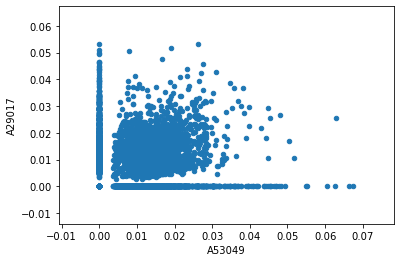

In [62]:
# We need to "transpose" our results so that the texts are the columns and the words are the rows.
transformed_results = readable_results.T 

# Then we can graph by selecting our two texts
transformed_results.plot.scatter('A53049','A29017')

You can see there are lots of words along the x- and y-axes that only appear in one text or the other. But there are plenty of words that appearn in both, with varying Tf-Idf scores.

The words we're interested in will have high Tf-Idf scores in both texts---those are the words that most account for the high similarity score between these two books. We'd like to label those words on this graph.

First, we can subselect a set of words based on their TF-Idf scores in the two columns we care about. This will create a new, much smaller DataFrame:

In [63]:
filtered_results = transformed_results[((transformed_results['A53049'] > 0.04) & (transformed_results['A29017'] > 0.005)) | ((transformed_results['A29017'] > 0.04) & (transformed_results['A53049'] > 0.005)) | ((transformed_results['A29017'] > 0.03) & (transformed_results['A53049'] > 0.03))] 
filtered_results

,B02845,A51130,A36358,A28171,A51877,A60482,A32566,A35206,A35114,A32207,...,A59614,A53049,A32567,A38630,A32559,A60948,A53818,A57156,A65985,A41955
liquor,0.0,0.036426,0.000000,0.000000,0.0,0.022491,0.0,0.0,0.000000,0.0,...,0.0,0.027102,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
chemist,0.0,0.021048,0.000000,0.000000,0.0,0.008530,0.0,0.0,0.000000,0.0,...,0.0,0.031120,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
figure,0.0,0.000000,0.014658,0.009893,0.0,0.017729,0.0,0.0,0.000000,0.0,...,0.0,0.037536,0.0,0.0,0.0,0.0,0.0,0.0,0.009958,0.000000
metal,0.0,0.000000,0.020051,0.000000,0.0,0.012843,0.0,0.0,0.000000,0.0,...,0.0,0.023320,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011752
mineral,0.0,0.000000,0.000000,0.008344,0.0,0.020664,0.0,0.0,0.000000,0.0,...,0.0,0.036862,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
finite,0.0,0.000000,0.000000,0.024130,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.044340,0.0,0.0,0.0,0.0,0.0,0.0,0.026685,0.000000
sensitive,0.0,0.000000,0.000000,0.008754,0.0,0.019826,0.0,0.0,0.000000,0.0,...,0.0,0.050490,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
perception,0.0,0.000000,0.000000,0.000000,0.0,0.022340,0.0,0.0,0.000000,0.0,...,0.0,0.062897,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014504
production,0.0,0.000000,0.000000,0.000000,0.0,0.020664,0.0,0.0,0.000000,0.0,...,0.0,0.038184,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
immaterial,0.0,0.000000,0.000000,0.000000,0.0,0.008530,0.0,0.0,0.000000,0.0,...,0.0,0.042829,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


These are the 11 words which drive the similarity between Cavendish and Boyle. You could adjust the threshold values in the above filter to get a bigger or smaller list of words.

And we can add these words as labels to our graph in order to see their relative Tf-Idf weights:

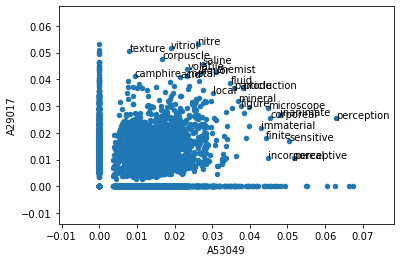

In [64]:
ax = transformed_results.plot.scatter('A53049','A29017')
for txt in filtered_results.index:
    x = transformed_results.A53049.loc[txt]
    y = transformed_results.A29017.loc[txt]
    ax.annotate(txt, (x,y))
plt.show()

This graph tells us quite a bit about the similarity between these two texts. Words like "texture" and "corpuscles" have very high Tf-Idf scores in Boyle and somewhat high scores in Cavendish. Words like "perception" and "sensitive" have very high scores in Cavendish and only somewhat high in Boyle. And a few select terms, like "microscope," "mineral," and "corporeal," have high scores in both texts. This scientific vocabulary is exactly what we might expect to see driving similarity between two early science texts.

### Visualizing Texts

In addition to visualizing the words in just two texts, it can also be helpful to visualize all of our texts at once. We can create a visualization of our entire similarity matrix by making a heatmap: a chart where values are expressed as colors.

Using the [`seaborn`](https://seaborn.pydata.org/index.html) library, this is as easy as inputting our cosine distance DataFrame into a single function:

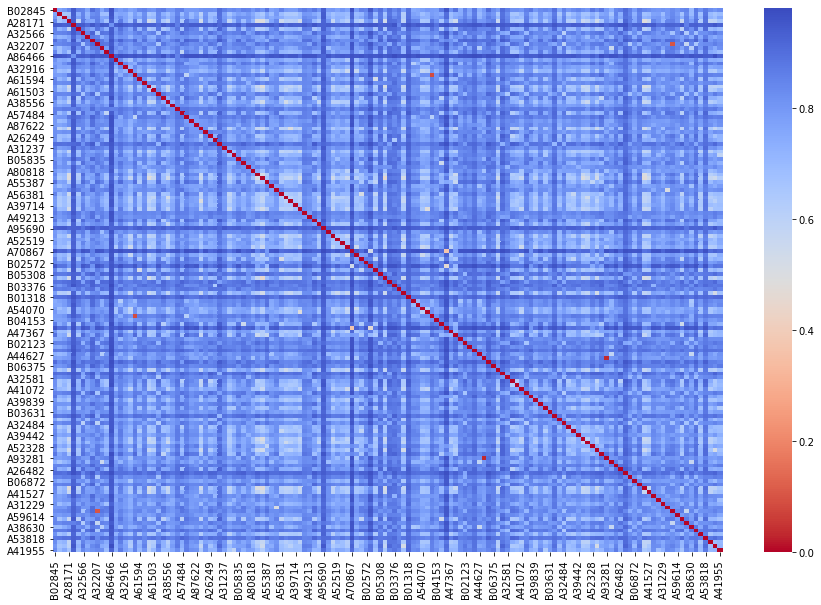

In [65]:
f, ax = plt.subplots(figsize=(15, 10)) # This line just makes our heatmap a little bigger
sns.heatmap(cosine_df, cmap='coolwarm_r') # This function creates the heatmap

Like the word-based visualization above, this heatmap of texts is also showing us a lot that we couldn't see just by looking at a table of numbers.

Mainly, we can see that most of the texts are not all that similar! Most of the values are showing up as blue, on the coolest end of our heatmap spectrum. [Look at the key on the right, and remember that when measuring distance higher values mean that two texts are farther apart.] This makes sense, as a group of texts published in just one year won't necessarily use much of the same vocabulary.

Down the center diagonal of our heatmap is a solid red line. This is where a text matches with itself in our matrix, and texts are always perfectly similar to themselves.

But all is not lost: notice that some of the points are much lighter blue. These texts are more similar than the dark blue intersections, so there is some variation in our graph. And a few points that are not along the diagonal are dark red, indicating quite low distance, i.e. very high similarity. You would need to use the metadata techniques we learned above to get more information, but it's possible that these very similar texts were written by the same author or are about the same topics.

Visualization doesn't answer all our questions, but it allows us to view the similarity measures in a few different ways. And by seeing our data anew, we can generate more research questions that require further digging, a generative cycle.